# Bike Sharing Demand

In [1]:
import pandas
import numpy
import time
from pandas import Series, DataFrame, Panel, datetime
from datetime import datetime
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
import sklearn.model_selection as model_selection
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.cross_validation import KFold
import matplotlib.pyplot as plt

C:\Users\djablonski\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Data Loading
Load the training and testing data from the given CSV files

In [2]:
# X should not contain any of the label columns and y is simply the count
train_data = pandas.read_csv('data/train.csv')
X = train_data.drop(['count', 'casual', 'registered'], axis=1)
y = train_data['count']
y1 = train_data['casual']
y2 = train_data['registered']

test_data = pandas.read_csv('data/test.csv')

### Evaluation
The scoring function is the Root Mean Squared Logarithmic Error given by

$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $

Where

* $n$ is the number of hours in the test set
* $pi$ is your predicted count
* $ai$ is the actual count
* $log(x)$ is the natural logarithm

In [3]:
def rmsle(y, y_):
    log1 = numpy.nan_to_num(numpy.array([numpy.log(v + 1) 
                                         for v 
                                         in y]))
    log2 = numpy.nan_to_num(numpy.array([numpy.log(v + 1) 
                                         for v 
                                         in y_]))
    calc = (log1 - log2) ** 2
    return numpy.sqrt(numpy.mean(calc))

# create a custom scorer to be used in grid search, etc
scorer = metrics.make_scorer(score_func=rmsle, 
                             greater_is_better=False)

### Submission
In order to submit to Kaggle we have to generate predictions from the test set and output them to a file with the following format

~~~~
datetime,count
2011-01-20 00:00:00,0
2011-01-20 01:00:00,0
2011-01-20 02:00:00,0
...
...
~~~~

In [4]:
def generate_kaggle_submission(
        transformer, 
        regressor, 
        X_train, 
        y_train,
        test_data):
    
    # train the final model on the transformed data
    regressor.fit(transformer(X_train), 
                  y_train)

    # create a dataframe containing the datetimes to predict and then
    # add the predictions from the trained pipeline
    predictions = pandas.DataFrame(test_data['datetime'])
    predictions['count'] = regressor.predict(transformer(test_data)).astype('int')

    # create a submission file from the result tagged with the current time
    predictions.to_csv('submissions/submission{0}.csv'.format(str(int(time.time()))), 
                       sep=',', 
                       index=False)

### Partition Data

Split out the given training data into a train and a test set and use all of the available parameters

In [5]:
def partition_train_test(
        X, 
        y,
        y1,
        y2,
        split_percentage = .8):
    mask = numpy.random.rand(len(X)) < split_percentage
    X_train = X[mask]
    y_train = y[mask]
    y1_train = y1[mask]
    y2_train = y2[mask]
    X_test = X[~mask]
    y_test = y[~mask]
    y1_test = y1[~mask]
    y2_test = y2[~mask]
    
    print('{0} training examples and {1} testing examples'.format(len(X_train), 
                                                                  len(X_test)))
    
    return X_train, X_test, y_train, y_test, y1_train, y1_test, y2_train, y2_test

X_train, X_dev, y_train, y_dev, y1_train, y1_dev, y2_train, y2_dev = partition_train_test(X, y, y1, y2)

13801 training examples and 3578 testing examples


### Initial Feature Engineering

All of the data is already numeric except for datetime. Replace the datetime with distinct numeric parameters for hour, day, month and year. Then display the summary of the data as a sanity check.

In [ ]:
def get_date(my_datetime):
    return datetime.strptime(
        my_datetime, 
        '%Y-%m-%d %H:%M:%S')

def simple_feature_eng(data):
    copy = data.copy()
    copy['hour'] = copy.datetime.apply(lambda x: x.split()[1].split(':')[0]).astype('int')
    copy['day'] = copy.datetime.apply(lambda x: x.split()[0].split('-')[2]).astype('int')
    copy['month'] = copy.datetime.apply(lambda x: x.split()[0].split('-')[1]).astype('int')
    copy['year'] = copy.datetime.apply(lambda x: x.split()[0].split('-')[0]).astype('int')
    copy = copy.drop(['datetime'], axis=1)
    return copy

print(simple_feature_eng(X).describe())

### Initial Regressor

Decision Tree ensembles, particularly Boosted Decision Trees, have fairly good performance over a wide variety of use cases as demonstrated [here](https://ucb-mids.s3.amazonaws.com/prod/DATASCI+W207+Intro+to+Machine+Learning/Readings/caruana.icml06.pdf). Since the values for count have to be both non-negative and an integer we will subclass the Gradient Boosting Regressor to force the predictions to accomidate that requirement.

In [ ]:
class PositiveIntegerGradientBoostingRegressor(GradientBoostingRegressor):
    def predict(
            self, 
            X):
        prediction = super(
            PositiveIntegerGradientBoostingRegressor, 
            self).predict(X)
        return numpy.around(prediction.clip(0))

### Model Fit

We will use GridSearch to tune over a range values of max depth for a Gradient Descent Boosted Decision Tree regressor preceeded by our initial feature engineering transformer. We will also use the given RMSLE error function as a custom scoring function. Fit the model and evaluate the resulting predictions on the held out dev data set.

In [ ]:
def simple_grid_search(
        regressor, 
        transformer,
        param_grid, 
        X_train, 
        y_train, 
        X_dev, 
        y_dev):
    pipeline = Pipeline([('reg', regressor)])

    model = model_selection.GridSearchCV(pipeline, 
                                         param_grid, 
                                         scorer,
                                         n_jobs=-1)
    
    transformed_X_train = transformer(X_train)
    transformed_X_dev = transformer(X_dev)
    model.fit(transformed_X_train,
              y_train)
    
    print('Best Parameters: {0}'.format(model.best_params_))
    print('RMSLE: {0}'.format(rmsle(y_dev, 
                                    model.predict(transformed_X_dev))))
    return model.best_params_


In [ ]:
hyperparameters = simple_grid_search(
    PositiveIntegerGradientBoostingRegressor(n_estimators=100), 
    simple_feature_eng,
    [{'reg__max_depth': list(range(3, 12))}],
    X_train,
    y_train,
    X_dev,
    y_dev)

##### Initial Submission Generation
Generate the first submission to Kaggle. This resulted in a score of **.50555**.

In [ ]:
# best hyperparameters found from simple_grid_search above
max_depth = 11

generate_kaggle_submission(simple_feature_eng,
                           PositiveIntegerGradientBoostingRegressor(
                               n_estimators=1000, 
                               max_depth=max_depth),
                           X,
                           y,
                           test_data)

## Part 1: Initial Feature Engineering
### Exploratory data analysis & feature engineering - 1

#### 1. Hourly trend of bike demand 
The figure below shows the trend of bike demand aggregated hourly for the traininig dataset. The trend highlights the gradual increase in demand as we apporach morning office hours, tapering off during the day time. the demand again picks up in after office hours.
<img src="HourlyBikeCountTrend.png" style="width: 600px;"/>

#### 2. Hourly trend of Registered and Casual bike demand
The figure below shows the trend of bike demand aggregated hourly for Casual and Registered bike users over the entire traininig dataset. The figure highlights the differences of trends observed for these two groups. The registered users have similar trend menioned in point 1 above. The demand for casual users peaks in the office hours and trails down during the non office hours. 
<img src="HourlyBikeCountTrendRegisteredVsCasual.png" style="width: 600px;"/>

#### 3. Weekday trend of Registered and Casual bike demand
The figure below shows the demand curve for Casual and Registered users for day of a week aggregated for the training data set. The demand for casual users is high on weekends while that of registered users is high during weekdays.
<img src="WkdayBikeCountTrendRegisteredVsCasual.png" style="width: 500px;"/>

#### 4. Impact of working and non-working day on demand from registered and casual bikers
The trend below highlghts the differences on the bike demand based on working day and non working day. Casual and registered bike users exhibit similar characteristics on non working day.
<img src="WorkNonworkBikeCountTrendRegisteredVsCasual.png" style="width: 1000px;"/>

#### 5. Skewness
Looking at a very simple histogram of the count, registered, and casual variables we can see that there is substantial skew to the right.

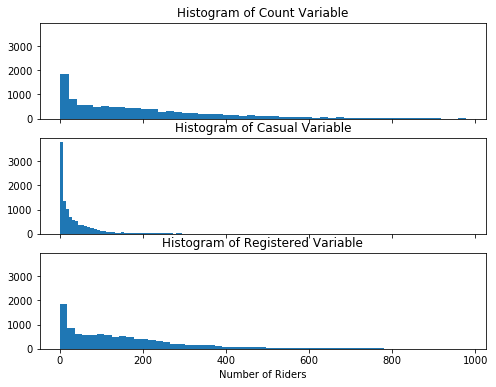

In [132]:
f, ax = plt.subplots(
    3, 
    sharex=True, 
    sharey=True, 
    figsize=(8, 6))
ax[0].hist(y, 50)
ax[0].set_title('Histogram of Count Variable')
ax[1].hist(y1, 50)
ax[1].set_title('Histogram of Casual Variable')
ax[2].hist(y2, 50)
ax[2].set_title('Histogram of Registered Variable')
ax[2].set_xlabel('Number of Riders')
plt.show()

## Observations
Based on the above exploratory analysis and visual inspection of the data we have made the following observations:

1. The behavior of the registered bikers is very different from the behavior of the casual bikers in terms of time of day, date of week, etc.
2. The training set of data consists of only the first 20 days of any given month and the testing data always consists of the last 7-11 days.
3. The mean values and standard deviations vary widely among different parameters.
4. Generally speaking model displays some signs of overfitting given the training RMSE of .35 and the testing RMSE of over .5. 
5. The dependant variables have substantial rightward skew.

## Plan
1. To account for the difference in behavior between the two groups we will construct 2 completely distinct models and sum the resulting predictions to get the overall demand. In this way we can account for the disparate behavior between the two customer types.
2. We will create an ensemble of sorts by using a purely time-series method to forecast the demand on the last 7-11 days of each month. Because the monthly data itself is stationary and fairly periodic this should give us a reasonable (on the average) estimate of the remaining days demand each month. This data will then become part of training data and hopefully will alleviate some of the inaccuracies caused by prediction from ranges of parameters not in the training set.
3. We will simply standardize all of the features to zero mean and unit variance.
4. We may try choosing some other core model than Boosted Decision Trees even though this variant of Decision Trees (limiting depth, iterating over multiple trees) generally limits overfitting. A simple model that is less inclined to overfit such as Logistic Regression may work better.
5. Remove outliers and/or predict a log transformed version of the output.

## Step 1: Casual/Registered Model Split
Working from part one of the plan we will simply break the prediction down into two models: one predicting the number of registered users in a day and the other predicting the number of casual users. In addition we will take a simple log(x+1) transform on the regressor to normalize the dependant variables, and reverse the transform for the submission.

In [71]:
casual_hyperparameters = simple_grid_search(
    GradientBoostingRegressor(n_estimators=100), 
    simple_feature_eng,
    [{'reg__max_depth': list(range(3, 12))}],
    X_train,
    numpy.log1p(y1_train + 1),
    X_dev,
    numpy.log1p(y1_dev + 1))

registered_hyperparameters = simple_grid_search(
    GradientBoostingRegressor(n_estimators=100), 
    simple_feature_eng,
    [{'reg__max_depth': list(range(3, 12))}],
    X_train,
    numpy.log1p(y2_train + 1),
    X_dev,
    numpy.log1p(y2_dev + 1))

Transforming dataset with 9 features
Fitting model with 12 features
Best Parameters: {'reg__max_depth': 6}
RMSLE: 0.13698979192894803
Transforming dataset with 9 features
Fitting model with 12 features
Best Parameters: {'reg__max_depth': 4}
RMSLE: 0.07704778792073358


#####  Second Submission Generation
Generate our second submission to Kaggle for a score. This requires and input-output transformation of the count variable and summing the resulting generation of scores from the casual and registered users. This resulted in a submission score of **.46154** which was a vast improvement over our previous score.

In [73]:
# best hyperparameters found from simple_grid_search above
casual_max_depth = 6
registered_max_depth = 4

casual_regressor = GradientBoostingRegressor(n_estimators=1000, 
                                             max_depth=casual_max_depth)
registered_regressor = GradientBoostingRegressor(n_estimators=1000, 
                                                 max_depth=registered_max_depth)

# train the final models on the transformed data and the transformed labels
casual_regressor.fit(simple_feature_eng(X), 
                     numpy.log1p(y1 + 1))
registered_regressor.fit(simple_feature_eng(X), 
                         numpy.log1p(y2 + 1))

# create a dataframe containing the datetimes to predict
predictions = pandas.DataFrame(test_data['datetime'])

# predict for both the casual and registered users
casual_predictions = casual_regressor.predict(simple_feature_eng(test_data))
registered_predictions = registered_regressor.predict(simple_feature_eng(test_data))

# reverse the transform for both predictions and then add the result
predictions['count'] = (numpy.exp(casual_predictions) - 1 + 
                        numpy.exp(registered_predictions) - 1).astype('int')

# create a submission file from the result tagged with the current time
predictions.to_csv('submissions/submission{0}.csv'.format(str(int(time.time()))), 
                   sep=',', 
                   index=False)

## Part 2: Model Selection
In addition to splitting out the models as done above, we would like to perform a search over different types of models as well as their hyperparameters. The above improvement was primarily due to the log transform of the output data which indicates that the model is somewhat sensitive to outliers. In addition some simple feature engineering changes (not shown in this notebook) improved the score on the training set but worsened the score on the test set. These two phenomenon are classic indicators of model overfitting. In order to combat that overfitting we would like to try a variety of different models. In addition there is some [evidence](http://www.jmlr.org/papers/volume11/cawley10a/cawley10a.pdf) that simple cross-validation for both model selection and performance estimation can result in further overfitting. Thus we will use nested cross-validation to select a model for the registered and casual users.

In [64]:
def nested_cross_validation(
        models, 
        params, 
        transformer,
        X, 
        y):
    transformed_X = transformer(X)
    scores = [[] for _ in range(len(models))]
    
    for tr, ts in KFold(len(transformed_X)):
        for i, (model, param) in enumerate(zip(models, params)):
            model = model_selection.GridSearchCV(
                model, 
                param, 
                scorer,
                n_jobs=4)
            model.fit(transformed_X.iloc[tr], 
                      y[tr])
            scores[i].append(rmsle(y[ts], 
                                   model.predict(transformed_X.iloc[ts])))
    return zip(models, np.mean(scores, 1))
    

regressors = [SVR(), 
              RandomForestRegressor(),
              GradientBoostingRegressor(),
              Ridge(),
              Lasso()]
parameters = [{'C': [0.01, 0.05, 0.1, .5, 1]}, 
              {'max_depth': list(range(3, 12))},
              {'max_depth': list(range(3, 12))},
              {'alpha': [0.01, 0.05, 0.1, .5, 1]},
              {'alpha': [100, 20, 10, 2, 1]}]

casual_results = nested_cross_validation(
                    regressors,
                    parameters,
                    simple_feature_eng,
                    X,
                    numpy.log1p(y1 + 1))

print('{:<30} {:<15}'.format('Model (casual)', 'RMSLE'))
print('-------------------------------------')
for i in casual_results:
    print('{:<30} {:<15,.4f}'.format(i[0].__class__.__name__, 
                                               i[1]))
    
registered_results = nested_cross_validation(
                        regressors,
                        parameters,
                        simple_feature_eng,
                        X,
                        numpy.log1p(y2 + 1))

print('\n')
print('{:<30} {:<15}'.format('Model (registered)', 'RMSLE'))
print('-------------------------------------')
for i in registered_results:
    print('{:<30} {:<15,.4f}'.format(i[0].__class__.__name__, 
                                               i[1]))

Model (casual)                 RMSE           
-------------------------------------
SVR                            0.3398         
RandomForestRegressor          0.1639         
GradientBoostingRegressor      0.1571         
Ridge                          0.2590         
Lasso                          0.2802         
Model (registered)             RMSE           
-------------------------------------
SVR                            0.2712         
RandomForestRegressor          0.1173         
GradientBoostingRegressor      0.1034         
Ridge                          0.2223         
Lasso                          0.2415         


For both casual and registered users Random Forrest and Gradient Descent Boosted Decision Trees produce superior results as compared to any other regression model. Since they are both very similar in terms of their RMSLE we will create a simple ensemble model that averages the output of the two models.

To be more thorough with this iteration we perform a grid search over all relevant parameters rather than arbitrarily setting n_estimators in the GradientBoostingRegressor as in previous iterations.

In [79]:
print('Casual user GradientBoostingRegressor')
casual_gb_hyperparameters = simple_grid_search(
    GradientBoostingRegressor(), 
    simple_feature_eng,
    {'reg__max_depth': list(range(3, 12)),
     'reg__n_estimators': [100, 200, 300, 400, 500, 1000]},
    X_train,
    numpy.log1p(y1_train + 1),
    X_dev,
    numpy.log1p(y1_dev + 1))

print('\n')
print('Registered user GradientBoostingRegressor')
registered_gb_hyperparameters = simple_grid_search(
    GradientBoostingRegressor(), 
    simple_feature_eng,
    {'reg__max_depth': list(range(3, 12)),
     'reg__n_estimators': [100, 200, 300, 400, 500, 1000]},
    X_train,
    numpy.log1p(y2_train + 1),
    X_dev,
    numpy.log1p(y2_dev + 1))

Casual user GradientBoostingRegressor
Best Parameters: {'reg__max_depth': 6, 'reg__n_estimators': 100}
RMSLE: 0.13703367972045005


Registered user GradientBoostingRegressor
Best Parameters: {'reg__max_depth': 3, 'reg__n_estimators': 300}
RMSLE: 0.0747842138473513


In [80]:
print('Casual user RandomForestRegressor')
casual_rf_hyperparameters = simple_grid_search(
    RandomForestRegressor(), 
    simple_feature_eng,
    {'reg__min_samples_split': list(range(3, 12)),
     'reg__n_estimators': [100, 500, 1000, 2000, 5000]},
    X_train,
    numpy.log1p(y1_train + 1),
    X_dev,
    numpy.log1p(y1_dev + 1))

print('Registered user RandomForestRegressor')
registered_rf_hyperparameters = simple_grid_search(
    RandomForestRegressor(), 
    simple_feature_eng,
    {'reg__min_samples_split': list(range(3, 12)),
     'reg__n_estimators': [100, 500, 1000, 2000, 5000]},
    X_train,
    numpy.log1p(y2_train + 1),
    X_dev,
    numpy.log1p(y2_dev + 1))

Casual user RandomForestRegressor
Best Parameters: {'reg__min_samples_split': 11, 'reg__n_estimators': 2000}
RMSLE: 0.13989044089880226
Registered user RandomForestRegressor
Best Parameters: {'reg__min_samples_split': 8, 'reg__n_estimators': 500}
RMSLE: 0.0769744595514548


##### Third Submission Generation
Generate our third submission to Kaggle for a score. This requires training 4 models: 2 for the casual users and 2 for the registered users. These models each use the optimal hyperparameters found above. The results of each casual and registered model are averaged together, and then summed to get a final score for 'count'. This resulted in a submission score of ***.44112***.

In [83]:
# best hyperparameters found from simple_grid_search above
casual_gb_max_depth = 6
casual_gb_n_estimators = 100
registered_gb_max_depth = 3
registered_gb_n_estimators = 300

casual_rf_min_samples_split = 11
casual_rf_n_estimators = 2000
registered_rf_min_samples_split = 8
registered_rf_n_estimators = 500

casual_gb_regressor = GradientBoostingRegressor(n_estimators=casual_gb_n_estimators, 
                                                max_depth=casual_gb_max_depth)
registered_gb_regressor = GradientBoostingRegressor(n_estimators=registered_gb_n_estimators, 
                                                    max_depth=registered_gb_max_depth)
casual_rf_regressor = RandomForestRegressor(min_samples_split=casual_rf_min_samples_split,
                                             n_estimators=casual_rf_n_estimators)
registered_rf_regressor = RandomForestRegressor(min_samples_split=registered_rf_min_samples_split,
                                                 n_estimators=registered_rf_n_estimators)

# train the final models on the transformed data and the transformed labels
casual_gb_regressor.fit(simple_feature_eng(X), 
                        numpy.log1p(y1 + 1))
casual_rf_regressor.fit(simple_feature_eng(X), 
                        numpy.log1p(y1 + 1))
registered_gb_regressor.fit(simple_feature_eng(X), 
                            numpy.log1p(y2 + 1))
registered_rf_regressor.fit(simple_feature_eng(X), 
                            numpy.log1p(y2 + 1))

# create a dataframe containing the datetimes to predict
predictions = pandas.DataFrame(test_data['datetime'])

# predict for both the casual and registered users and reverse the transformation
casual_gb_predictions = numpy.exp(casual_gb_regressor.predict(simple_feature_eng(test_data))) - 1
casual_rf_predictions = numpy.exp(casual_rf_regressor.predict(simple_feature_eng(test_data))) - 1
registered_gb_predictions = numpy.exp(registered_gb_regressor.predict(simple_feature_eng(test_data))) - 1
registered_rf_predictions = numpy.exp(registered_rf_regressor.predict(simple_feature_eng(test_data))) - 1

# the casual and registered predictions are half of the sum from the two models
casual_predictions = (casual_gb_predictions + casual_rf_predictions) / 2.0
registered_predictions = (registered_gb_predictions + registered_rf_predictions) / 2.0

# add the casual and registered predictions and convert to an integer
predictions['count'] = (casual_predictions + registered_predictions).astype('int')

# create a submission file from the result tagged with the current time
predictions.to_csv('submissions/submission{0}.csv'.format(str(int(time.time()))), 
                   sep=',', 
                   index=False)

## Part 3: Improved Feature Engineering
### (Exploratory data analysis & feature engineering - 2)

### 1. Impact of seasons on demand from registered and casual bikers
The trend below shows the impact of seasons on the bike demand again keeping the distinction between casual and registered bikers. Spring season adversely impacts the demand for both registered and causual bikers.
<img src="SeasonsBikeCountTrendRegisteredVsCasual.png" style="width: 1000px;"/>

### 2. Impact of weather on demand from registered and casual bikers
The trend below shows the impact of weather on the bike demand again keeping the distinction between casual and registered bikers. The trend clearly shows that as the weather changes from 1 (clear and sunny) to 2: Mist + Cloudy to a 3: Light Snow and 4: Heavy Rain, the bike demand slows down for both the user types.
<img src="WeatherBikeCountTrendRegisteredVsCasual.png" style="width: 1000px;"/>

### 3. Impact of windspeed on demand from registered and casual bikers
The trend below shows the impact of windspeed on the bike demand again keeping the distinction between casual and registered bikers. The continoous variable windspeed has been grouped into 5 bins.(0-9; 10-19; 20-29; 30-39; 40-49; 50 and above) A windspeed of 10-19 seems to be an ideal one for bikers of both groups and as the windspeed decreases to less than 10 or increases beyond 20, it has an adverse impact on demand.
<img src="WindspeedBikeCountTrendRegisteredVsCasual.png" style="width: 1000px;"/>

### 4. Impact of temperature on demand from registered and casual bikers
The trend below shows the impact of temperature on the bike demand again keeping the distinction between casual and registered bikers. The continoous variable temperature has been grouped into 4 bins.(0-9; 10-19; 20-29; 30 and above) A mediterrenean temp of 10-19 seems to be an ideal one for bikers of both groups and as the temperature gets to either extreme, it has an adverse impact on demand.
<img src="TempBikeCountTrendRegisteredVsCasual.png" style="width: 1000px;"/>


Possible Additions
* Normalize parameters
* Remove outliers
* Add categorical parameters
* Create bins for some parameters (hour, windspeed)

In [13]:
def binarize(data, mask_string, mask_value):
    if data[mask_string] == mask_value:
        val = 1
    else:
        val = 0
    return val
    
def binarize_feature_eng(data):
    data['dayofweek'] = data.datetime.apply(lambda x: pandas.to_datetime(get_date(x)).dayofweek)
    
    copy = simple_feature_eng(data)
    
    copy['is_spring'] = copy.apply(binarize, mask_string = 'season', mask_value = 1, axis = 1)
    copy['is_summer'] = copy.apply(binarize, mask_string = 'season', mask_value = 2, axis = 1)
    copy['is_fall'] = copy.apply(binarize, mask_string = 'season', mask_value = 3, axis = 1)
    copy['is_winter'] = copy.apply(binarize, mask_string = 'season', mask_value = 4, axis = 1)
    copy = copy.drop(['season'], axis=1)
    
    copy['is_clear'] = copy.apply(binarize, mask_string = 'weather', mask_value = 1, axis = 1)
    copy['is_mist'] = copy.apply(binarize, mask_string = 'weather', mask_value = 2, axis = 1)
    copy['is_light_snow'] = copy.apply(binarize, mask_string = 'weather', mask_value = 3, axis = 1)
    copy['is_snow'] = copy.apply(binarize, mask_string = 'weather', mask_value = 4, axis = 1)
    copy = copy.drop(['weather'], axis=1)
    copy = copy.drop(['day'], axis = 1)
    copy = copy.drop(['month'], axis = 1)
    
    return copy

            holiday    workingday         temp         atemp      humidity  \
count  10886.000000  10886.000000  10886.00000  10886.000000  10886.000000   
mean       0.028569      0.680875     20.23086     23.655084     61.886460   
std        0.166599      0.466159      7.79159      8.474601     19.245033   
min        0.000000      0.000000      0.82000      0.760000      0.000000   
25%        0.000000      0.000000     13.94000     16.665000     47.000000   
50%        0.000000      1.000000     20.50000     24.240000     62.000000   
75%        0.000000      1.000000     26.24000     31.060000     77.000000   
max        1.000000      1.000000     41.00000     45.455000    100.000000   

          windspeed     dayofweek          hour          year     is_spring  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      12.799395      3.013963     11.541613   2011.501929      0.246739   
std        8.164537      2.004585      6.915838      0.50001

In [9]:
casual_hyperparameters = simple_grid_search(
    GradientBoostingRegressor(n_estimators=100), 
    binarize_feature_eng,
    [{'reg__max_depth': list(range(3, 12))}],
    X_train,
    numpy.log1p(y1_train + 1),
    X_dev,
    numpy.log1p(y1_dev + 1))

registered_hyperparameters = simple_grid_search(
    GradientBoostingRegressor(n_estimators=100), 
    binarize_feature_eng,
    [{'reg__max_depth': list(range(3, 12))}],
    X_train,
    numpy.log1p(y2_train + 1),
    X_dev,
    numpy.log1p(y2_dev + 1))

NameError: name 'simple_grid_search' is not defined

##### Fourth Submission Generation

Generate our fourth submission to Kaggle for a score. This resulted in a submission score of .3845.


In [14]:
# best hyperparameters found from simple_grid_search above
casual_max_depth = 6
registered_max_depth = 4

casual_regressor = GradientBoostingRegressor(n_estimators=1000, 
                                             max_depth=casual_max_depth)
registered_regressor = GradientBoostingRegressor(n_estimators=1000, 
                                                 max_depth=registered_max_depth)

# train the final models on the transformed data and the transformed labels
casual_regressor.fit(binarize_feature_eng(X), 
                     numpy.log1p(y1 + 1))
registered_regressor.fit(binarize_feature_eng(X), 
                         numpy.log1p(y2 + 1))

# create a dataframe containing the datetimes to predict
predictions = pandas.DataFrame(test_data['datetime'])

# predict for both the casual and registered users
casual_predictions = casual_regressor.predict(binarize_feature_eng(test_data))
registered_predictions = registered_regressor.predict(binarize_feature_eng(test_data))

# reverse the transform for both predictions and then add the result
predictions['count'] = (numpy.exp(casual_predictions) - 1 + 
                        numpy.exp(registered_predictions) - 1).astype('int')

# create a submission file from the result tagged with the current time
predictions.to_csv('submissions/submission{0}.csv'.format(str(int(time.time()))), 
                   sep=',', 
                   index=False)

## Timeseries Forecast

### 1. First we look for the best parameters for the seasonal ARIMA model


In [ ]:
import statsmodels.api as sm
import itertools

train_data = pandas.read_csv('data/train.csv') 
X = train_data.drop(['count', 'casual', 'registered'], axis=1)
y = train_data['count']
y1 = train_data['casual']
y2 = train_data['registered']

test_data = pandas.read_csv('data/test.csv')

y1 = numpy.asarray(y1, dtype=numpy.float64)
y2 = numpy.asarray(y2, dtype=numpy.float64)

dates1 = pandas.date_range('1/1/2011', periods=456, freq='H')
Jan_11 = Series(y1[:456], index=dates1)

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 168) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(Jan_11,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

## Timeseries Forecast

### 2. Now we used the best parameters to model the monthly Time Series
The computing power needed for this case is more than we currently have so we look to use a simpler model

In [ ]:
dates1 = pandas.date_range('1/1/2011', periods=456, freq='H')
Jan_11c = Series(y1[:456], index=dates1)
Jan_11r = Series(y2[:456], index=dates1)

mod = sm.tsa.statespace.SARIMAX(Jan_11c,order=(0, 0, 1),seasonal_order=(1, 1, 0, 168),
                                enforce_stationarity=False,enforce_invertibility=False)

results = mod.fit()
predc = results.forecast(steps=288)
plt.plot(Jan_11c)
plt.plot(results.fittedvalues, color='red')
plt.plot(predc, color='black')
plt.show()

mod = sm.tsa.statespace.SARIMAX(Jan_11r,order=(0, 0, 0),seasonal_order=(1, 1, 0, 168),
                                enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
predr = results.forecast(steps=288)
plt.plot(Jan_11r)
plt.plot(results.fittedvalues, color='red')
plt.plot(predr, color='black')
plt.show()

## Timeseries Forecast

### 3. Now we used a simple weekly look back model for the monthly Time Series

In [2]:
train_data = pandas.read_csv('data/train.csv') 
test_data = pandas.read_csv('data/test.csv')
test_data['casual'] = 0
test_data['registered'] = 0
test_data['count'] = 0

peices = [train_data, test_data]
time_data = pandas.concat(peices)
time_data = time_data.reset_index(drop=True)

for i in range(17379):
    if time_data.iloc[i].loc['casual'] == 0 and time_data.iloc[i].loc['registered'] == 0:
        t = i - 168
        cas = time_data.get_value(t, 'casual')
        time_data['casual'][i] = cas
        reg = time_data.get_value(t, 'registered')
        time_data['registered'][i] = reg
        time_data['count'][i] = cas + reg
    
X = time_data.drop(['count', 'casual', 'registered'], axis=1)
y = time_data['count']
y1 = time_data['casual']
y2 = time_data['registered']

C:\Users\djablonski\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\djablonski\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\djablonski\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
